In [1]:
import os
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
base_dir = os.path.join("/Users", "sbussmann", "Development", "buda", "buda-ratings")
interim_dir = os.path.join(base_dir, 'data', 'interim')

In [3]:
league_id = 40264
winloss = pd.read_csv(os.path.join(interim_dir, "winloss_divprior_{}.csv".format(league_id)))

In [4]:
winloss.head()

,Team A,Team B,Team A Wins,Index A,Index B,Div A,Div B
0,AHOC,Gothrilla,True,0,1,4/3 Div 1,4/3 Div 1
1,AHOC,BBN,True,0,9,4/3 Div 1,4/3 Div 1
2,AHOC,Stonecutters,True,0,41,4/3 Div 1,5/2 Div 1
3,AHOC,FlowChart,True,0,2,4/3 Div 1,4/3 Div 1
4,AHOC,Lady and the BAMF,True,0,28,4/3 Div 1,4/3 Div 2


In [5]:
winloss = winloss.rename(columns={"Team A Wins": "teamAWon", "Index A": "indexA", "Index B": "indexB"})

In [6]:
winloss.head()

,Team A,Team B,teamAWon,indexA,indexB,Div A,Div B
0,AHOC,Gothrilla,True,0,1,4/3 Div 1,4/3 Div 1
1,AHOC,BBN,True,0,9,4/3 Div 1,4/3 Div 1
2,AHOC,Stonecutters,True,0,41,4/3 Div 1,5/2 Div 1
3,AHOC,FlowChart,True,0,2,4/3 Div 1,4/3 Div 1
4,AHOC,Lady and the BAMF,True,0,28,4/3 Div 1,4/3 Div 2


In [7]:
div_mapper = {
    "4/3 Div 1": 2.0,
    "4/3 Div 2": 0.0,
    "4/3 Div 3": -1.0,
    "5/2 Div 1": 2.0,
    "5/2 Div 2": 0.0,
    "5/2 Div 3": -1.0
}

In [8]:
winloss["muA"] = winloss["Div A"].apply(lambda x: div_mapper[x])
winloss["muB"] = winloss["Div B"].apply(lambda x: div_mapper[x])

In [9]:
winloss["teamAWon"] = winloss["teamAWon"].astype("int")

In [10]:
winloss.head()

,Team A,Team B,teamAWon,indexA,indexB,Div A,Div B,muA,muB
0,AHOC,Gothrilla,1,0,1,4/3 Div 1,4/3 Div 1,2.0,2.0
1,AHOC,BBN,1,0,9,4/3 Div 1,4/3 Div 1,2.0,2.0
2,AHOC,Stonecutters,1,0,41,4/3 Div 1,5/2 Div 1,2.0,2.0
3,AHOC,FlowChart,1,0,2,4/3 Div 1,4/3 Div 1,2.0,2.0
4,AHOC,Lady and the BAMF,1,0,28,4/3 Div 1,4/3 Div 2,2.0,0.0


In [12]:
wldict = {}
for col in ["indexA", "indexB", "teamAWon"]:
    wldict[col] = list(winloss[col].values)

In [13]:
wldict.keys()

dict_keys(['indexA', 'indexB', 'teamAWon'])

In [14]:
teams = set(np.append(winloss['Team A'].unique(), winloss['Team B'].unique()))

In [15]:
n_teams = len(teams)

In [16]:
n_games = len(winloss)

In [17]:
wldict["nTeams"] = n_teams
wldict["nGames"] = n_games

In [21]:
ratings_code = """
"""

In [22]:
sm = pystan.StanModel(model_code=ratings_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bddb90e1e93aae5433148fbfb388b3c2 NOW.


In [23]:
fit = sm.sampling(data=wldict, iter=1000, chains=4)

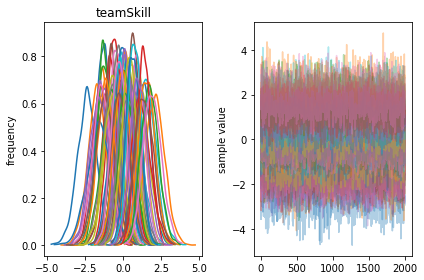

In [24]:
fit.plot()
plt.tight_layout()

In [25]:
traces = fit.extract()

In [26]:
traces.keys()

odict_keys(['teamSkill', 'lp__'])

In [27]:
skillTrace = traces['teamSkill']

In [28]:
meanratings = skillTrace.mean(axis=0)

In [29]:
meanratings

array([-2.3974064 , -1.22209441, -1.23773676, -0.61155811, -1.33430882,
       -0.03940512, -0.02797729,  0.12283814,  0.30493958,  0.65402901,
       -1.3158078 , -1.72175014, -1.23258711, -0.82457319, -1.53878844,
       -0.79594397, -0.41458294, -0.34798993, -0.6507827 , -0.06322377,
       -0.09098328,  0.2001853 ,  0.07251813,  0.1007075 ,  0.0268756 ,
        0.37576665,  0.50198721,  0.51320881,  0.9699971 ,  1.55631871,
        1.26938037,  2.13926038, -0.81937229, -0.22514739,  0.64355225,
        0.69556654,  0.92070367,  0.59173993,  1.15573481,  1.69894337,
       -1.56436967, -1.11226871,  0.20348399, -1.4119317 , -1.6034866 ,
       -1.19491396, -1.43147563, -0.77294305, -0.67544932, -0.24345638,
       -0.27753312, -0.06238716,  0.30486363,  1.16493296,  0.15082868,
       -0.18178387, -0.27905062,  0.29592242,  0.41495524,  0.74778333,
        0.67265656,  1.56872704,  1.76384268,  1.33270446,  1.04409928,
        1.40129471,  1.94141425])

In [30]:
names = []
for i, meanrating in enumerate(meanratings):
    if i in winloss['indexA'].values:
        index = winloss['indexA'] == i
        name = winloss.loc[index, 'Team A'].unique()[0]
    else:
        index = winloss['indexB'] == i
        name = winloss.loc[index, 'Team B'].unique()[0]
    names.append(name)

In [31]:
ratingsdf = pd.DataFrame({
    'mean_rating': meanratings
}, index=names)

In [32]:
ratingsdf

,mean_rating
AHOC,-2.397406
Gothrilla,-1.222094
FlowChart,-1.237737
GrassBurner,-0.611558
Zerg Rush!,-1.334309
Swingers,-0.039405
TuneSquad,-0.027977
Turtle Boy,0.122838
"Live Poultry, Fresh Killed (LPFK)",0.304940
BBN,0.654029
